In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['NFL Play by Play 2009-2018 (v5).csv', 'NFL Play by Play 2009-2016 (v3).csv', 'NFL Play by Play 2009-2017 (v4).csv']


In [2]:
def load_data_in_kaggle():
    df = pd.read_csv('../input/NFL Play by Play 2009-2018 (v5).csv')
    df['game_date'] = pd.to_datetime(df.game_date)
    df['game_year'] = df.game_date.dt.year
    df['game_month'] = df.game_date.dt.month
    df['game_day'] = df.game_date.dt.day
    df.play_type = df.play_type.map({'pass': 1, 'run': 0})
    
    df['year_home_team'] = df.game_year.astype(str) + '_' + df.home_team
    df['year_posteam'] = df.game_year.astype(str) + '_' + df.posteam
    df['year_away_team'] = df.game_year.astype(str) + '_' + df.away_team
    df['year_defteam'] = df.game_year.astype(str) + '_' + df.defteam
    df['year_posteam_score'] = df.posteam_score
    df['year_defteam_score'] = df.defteam_score
    df['success_first_down'] = ((df[df.down == 1].yards_gained / df[df.down == 1].ydstogo) >= .45)
    df['success_second_down'] = (((df[df.down == 2].yards_gained / df[df.down == 2].ydstogo) >= .6))
    df['success_third_down'] = ((df[df.down == 3].yards_gained / df[df.down == 3].ydstogo) >= 1)
    df.success_first_down = df.success_first_down.map({True: 1,False: 0})
    df.success_second_down = df.success_second_down.map({True: 1,False: 0})
    df.success_third_down = df.success_third_down.map({True:1, False: 0})
    df['posteam_has_lead'] = (df.posteam_score_post > df.defteam_score_post)
    df['posteam_is_trailing'] = (df.posteam_score_post < df.defteam_score_post)
    df['posteam_is_tied'] = (df.posteam_score_post == df.defteam_score_post)
    
    return df
df = load_data_in_kaggle()
df.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(449371, 270)

In [3]:
def concat_all(list_of_dfs):
    game_logs = list_of_dfs[0]
    for df in list_of_dfs[1:]:
        game_logs = pd.concat([game_logs, df])
    return game_logs


def get_game_logs():

    games = [int(game) for game in list(df.game_id.unique())]
    all_game_logs = []
      
    for game in games:
        
        
        game = df[df.game_id == game]

        game_logs = {'game_date': list(game.game_date.unique())[0],
                      'game_id': list(game.game_id.unique())[0]}
        game_logs = pd.DataFrame({'game_date': list(game.game_date.unique())[0],
                                   'game_id': list(game.game_id.unique())[0]}, index=[1])
        game_logs['away_team'] = list(game.away_team.unique())[0]
        game_logs['home_team'] = list(game.home_team.unique())[0]
        # home and away offense
        home_offense = game[game.posteam == game.home_team]
        away_offense = game[game.posteam == game.away_team]
        game_logs['home_rush_attempts'] = len(home_offense.rush_attempt[home_offense.rush_attempt == 1])
        game_logs['away_rush_attempts'] = len(away_offense.rush_attempt[away_offense.rush_attempt == 1])
        game_logs['home_pass_attempts'] = len(home_offense.pass_attempt[home_offense.pass_attempt == 1])
        game_logs['away_pass_attempts'] = len(away_offense.pass_attempt[away_offense.pass_attempt == 1])
        game_logs['home_drives'] = len(home_offense.drive.unique())
        game_logs['away_drives'] = len(away_offense.drive.unique())
        game_logs['home_def_sacks'] = len(away_offense.sack[away_offense.sack == True])
        game_logs['away_def_sacks'] = len(home_offense.sack[home_offense.sack == True])
        game_logs['home_off_sacked'] = len(home_offense.sack[home_offense.sack == True])
        game_logs['away_off_sacked'] = len(away_offense.sack[away_offense.sack == True])
        game_logs['home_dropbacks'] = len(home_offense.qb_dropback[home_offense.qb_dropback == 1])
        game_logs['away_dropbacks'] = len(away_offense.qb_dropback[away_offense.qb_dropback == 1])
        game_logs['home_qb_hit'] = len(home_offense.qb_hit[home_offense.qb_hit == True])
        game_logs['away_qb_hit'] = len(away_offense.qb_hit[away_offense.qb_hit == True])
        game_logs['home_score'] = game.total_home_score[game.game_seconds_remaining == 0].max()
        game_logs['away_score'] = game.total_away_score[game.game_seconds_remaining == 0].max()
        game_logs['home_points_allowed'] = game.total_away_score[game.game_seconds_remaining == 0].max()
        game_logs['away_points_allowed'] = game.total_home_score[game.game_seconds_remaining == 0].max()
        game_logs['home_off_YAC'] = home_offense.yards_after_catch.sum()
        game_logs['home_off_passing_yards'] = home_offense[home_offense.play_type == 1].yards_gained.sum()
        game_logs['away_off_passing_yards'] = away_offense[away_offense.play_type == 1].yards_gained.sum()
        game_logs['home_off_rush_yards'] = home_offense[home_offense.play_type == 0].yards_gained.sum()
        game_logs['away_off_rush_yards'] = away_offense[away_offense.play_type == 0].yards_gained.sum()
        game_logs['away_off_YAC'] = away_offense.yards_after_catch.sum()
        game_logs['home_firstdown_rush'] = home_offense.first_down_rush[home_offense.first_down_rush == True].sum()
        game_logs['away_firstdown_rush'] = away_offense.first_down_rush[away_offense.first_down_rush == True].sum()
        game_logs['home_firstdown_pass'] = home_offense.first_down_pass[home_offense.first_down_pass == True].sum()
        game_logs['away_firstdown_pass'] = away_offense.first_down_pass[away_offense.first_down_pass == True].sum()
        game_logs['home_off_third_down_conversion_rate'] = home_offense.third_down_converted.sum() / (home_offense.third_down_converted.sum() + home_offense.third_down_failed.sum())
        game_logs['home_off_third_down_attempts'] = home_offense.third_down_converted.sum() + home_offense.third_down_failed.sum()
        game_logs['away_off_third_down_conversion_rate'] = away_offense.third_down_converted.sum() / (away_offense.third_down_converted.sum() + away_offense.third_down_failed.sum())
        game_logs['away_off_third_down_attempts'] = away_offense.third_down_converted.sum() + away_offense.third_down_failed.sum()
        game_logs['home_off_fumbles'] = home_offense.fumble.sum()
        game_logs['home_off_interceptions'] = home_offense.interception.sum()
        game_logs['away_off_fumbles'] = away_offense.fumble.sum()
        game_logs['away_off_interceptions'] = away_offense.interception.sum()
        game_logs['home_off_TFL'] = home_offense.tackled_for_loss.sum()
        game_logs['away_off_TFL'] = away_offense.tackled_for_loss.sum()
        game_logs['home_off_rushTD'] = home_offense.rush_touchdown.sum()
        game_logs['away_off_rushTD'] = away_offense.rush_touchdown.sum()
        game_logs['home_off_passTD'] = home_offense.pass_touchdown.sum()
        game_logs['away_off_passTD'] = away_offense.pass_touchdown.sum()
        game_logs['home_off_first_down_success_rate'] = home_offense[home_offense.down == 1].success_first_down.mean()
        game_logs['home_off_second_down_success_rate'] = home_offense[home_offense.down == 2].success_second_down.mean()
        game_logs['home_off_third_down_success_rate'] = home_offense[home_offense.down == 3].success_third_down.mean()
        game_logs['away_off_first_down_success_rate'] = away_offense[away_offense.down == 1].success_first_down.mean()
        game_logs['away_off_second_down_success_rate'] = away_offense[away_offense.down == 2].success_second_down.mean()
        game_logs['away_off_third_down_success_rate'] = away_offense[away_offense.down == 3].success_third_down.mean()
        game_logs['home_team_pos_lead'] = home_offense.posteam_has_lead.sum()
        game_logs['home_team_pos_istrailing'] = home_offense.posteam_is_trailing.sum()
        game_logs['home_team_pos_tied'] = home_offense.posteam_is_tied.sum()
        game_logs['away_team_pos_lead'] = away_offense.posteam_has_lead.sum()
        game_logs['away_team_pos_istrailing'] = away_offense.posteam_is_trailing.sum()
        game_logs['away_team_pos_tied'] = away_offense.posteam_is_tied.sum()
        
        game_logs['home_team_pos_lead_pct'] = home_offense.posteam_has_lead.mean()
        game_logs['home_team_pos_istrailing_pct'] = home_offense.posteam_is_trailing.mean()
        game_logs['home_team_pos_tied_pct'] = home_offense.posteam_is_tied.mean()
        game_logs['away_team_pos_lead_pct'] = away_offense.posteam_has_lead.mean()
        game_logs['away_team_pos_istrailing_pct'] = away_offense.posteam_is_trailing.mean()
        game_logs['away_team_pos_tied_pct'] = away_offense.posteam_is_tied.mean()
        
        
        game_logs['home_off_air_yards'] = home_offense.air_yards.sum()
        game_logs['away_off_air_yards'] = away_offense.air_yards.sum()
        game_logs['home_shotgun_snaps'] = home_offense.shotgun.sum()
        game_logs['away_shotgun_snaps'] = away_offense.shotgun.sum()
        
        game_logs['20plus_yard_plays_home'] = (home_offense.yards_gained >= 20).sum()
        game_logs['20plus_yard_plays_away'] = (away_offense.yards_gained >= 20).sum()
        
        game_logs['home_team_pos_leading_run_plays'] = ((home_offense.play_type == 0) & (home_offense.posteam_has_lead == True)).sum()
        game_logs['home_team_pos_tied_run_plays'] = ((home_offense.play_type == 0) & (home_offense.posteam_is_tied == True)).sum()
        game_logs['home_team_pos_trailing_run_plays'] = ((home_offense.play_type == 0) & (home_offense.posteam_is_trailing == True)).sum()
        game_logs['away_team_pos_leading_run_plays'] = ((away_offense.play_type == 0) & (away_offense.posteam_has_lead == True)).sum()
        game_logs['away_team_pos_tied_run_plays'] = ((away_offense.play_type == 0) & (away_offense.posteam_is_tied == True)).sum()
        game_logs['away_team_pos_trailing_run_plays'] = ((away_offense.play_type == 0) & (away_offense.posteam_is_trailing == True)).sum()
        


        all_game_logs.append(game_logs)
    
    all_game_logs = concat_all(all_game_logs)
    all_game_logs['total_qb_hits'] = all_game_logs['away_qb_hit'] + all_game_logs['home_qb_hit']
    all_game_logs['total_game_dropbacks'] = all_game_logs['home_dropbacks'] + all_game_logs['away_dropbacks']
    all_game_logs['total_qbhits_per_dropback'] = all_game_logs['total_qb_hits'] / all_game_logs['total_game_dropbacks']
    all_game_logs['total_points'] = all_game_logs['home_score'] + all_game_logs['away_score']
    all_game_logs['home_win'] = (all_game_logs.home_score > all_game_logs.away_score)
    all_game_logs['game_date'] = pd.to_datetime(all_game_logs.game_date)
    all_game_logs['game_year'] = all_game_logs.game_date.dt.year
    all_game_logs['game_month'] = all_game_logs.game_date.dt.month
    all_game_logs['home_off_pass_ypa'] = all_game_logs['home_off_passing_yards'] / all_game_logs['home_pass_attempts']
    all_game_logs['away_off_pass_ypa'] = all_game_logs['away_off_passing_yards'] / all_game_logs['away_pass_attempts']
    all_game_logs['home_off_rush_ypa'] = all_game_logs['home_off_rush_yards'] / all_game_logs['home_rush_attempts']
    all_game_logs['away_off_rush_ypa'] = all_game_logs['away_off_rush_yards'] / all_game_logs['away_rush_attempts']
    all_game_logs['home_qb_hit_rate'] = all_game_logs.home_qb_hit / all_game_logs.home_dropbacks
    all_game_logs['away_qb_hit_rate'] = all_game_logs.away_qb_hit / all_game_logs.away_dropbacks
    all_game_logs['home_off_int_per_dropback'] = all_game_logs.home_off_interceptions / all_game_logs.home_dropbacks
    all_game_logs['away_off_int_per_dropback'] = all_game_logs.away_off_interceptions / all_game_logs.away_dropbacks
    all_game_logs['home_def_sack_differential'] = all_game_logs['home_def_sacks'] - all_game_logs['away_def_sacks']
    
    
    return all_game_logs

all_game_logs = get_game_logs()
all_game_logs = all_game_logs[all_game_logs.home_score != all_game_logs.away_score]
all_game_logs.shape

(2444, 92)

In [4]:
# note we are dropping any games that went into overtime. honestly its for the sake of time it'd take to clean the data versus the reward
# but games that we're close would probably be noisy data points anyways.

game_log_scores = all_game_logs[['game_id','home_team', 'away_team', 'home_score', 'away_score','home_win']]

In [5]:
# query play data

def query_play_data(df=df,drive=False,downs=False,runs=False,
                    passes=False,game_day=False,game_month=False,
                    game_year=False, team=False, posteam=False,
                    defteam=False, game_half=False, qtr=False,
                    qb_hit=False, two_point_attempt=False,
                    runs_and_passes=False, shotgun=False):
    
    # df = df may want to add this as a parameter.
    
    if drive:
        df = df[df.drive == drive]
    if downs:
        df = df[df.down <= downs]
    if runs:
        df = df[df.play_type == 0]
    if passes:
        df = df[df.play_type == 1]
    if runs_and_passes:
        df[(df.play_type == 0) | (df.play_type == 1)]
    if game_day:
        df = df[df.game_day == game_day]
    if game_month:
        df = df[df.game_month == game_month]
    if game_year:
        df = df[df.game_year == game_year]
    if team:
        df = df[(df.away_team == team) | (df.home_team == team)]
    if posteam:
        df = df[df.posteam == posteam]
    if defteam:
        df = df[df.defteam == defteam]
    if game_half:
        df = df[df.game_half == game_half]
    if qtr:
        df = df[df.qtr == qtr]
    if qb_hit:
        df = df[df.qb_hit == qb_hit] # one means the qb was hit.
    if two_point_attempt:
        df = df[df.two_point_attempt == two_point_attempt]
    if shotgun:
        df = df[df.shotgun == 1]
    
    return df  

In [6]:
run_plays = query_play_data(drive=1, downs=3, runs=True)
pass_plays = query_play_data(drive=1,downs=3, passes=True)
first_drive = query_play_data(drive=1, runs_and_passes=True)

run_plays.shape, pass_plays.shape, first_drive.shape

((6917, 270), (8307, 270), (21278, 270))

In [7]:
# make pretty
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
summary = first_drive.pivot_table(index='down', values='play_type').drop(4.0).rename({'play_type': 'Pass Percentage'}, axis='columns')
summary['Pass Percentage'] = round(summary['Pass Percentage'] * 100, 1)
summary['Run Percentage'] = 100 - summary['Pass Percentage']
summary.index = ['1st','2nd','3rd']
summary

,Pass Percentage,Run Percentage
1st,44.6,55.4
2nd,50.8,49.2
3rd,80.9,19.1


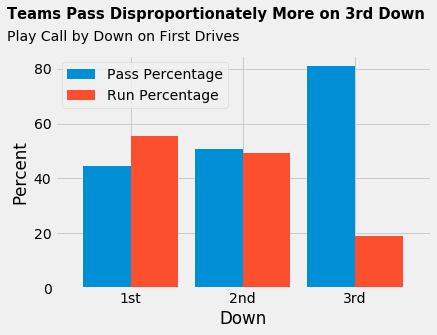

In [8]:
ax = summary.plot.bar(width=0.85)

ax.tick_params(labelrotation=0)

ax.text(x=-1.1, y= 98, s='Teams Pass Disproportionately More on 3rd Down', fontsize=14.7, fontweight='bold')
ax.text(x=-1.1, y= 90, s='Play Call by Down on First Drives', fontsize=14)


ax.set(xlabel='Down',
       ylabel='Percent',
       yticks=range(0,100,20));

In [9]:
first_drive_pivot = first_drive.pivot_table(index='down', values='yards_gained').drop(4.0, axis='index')
pass_pivot = pass_plays.pivot_table(index='down', values='yards_gained')
run_pivot = run_plays.pivot_table(index='down', values='yards_gained')
final_pivot = pd.DataFrame({'Yards per Pass Play':round(pass_pivot.yards_gained,3),
                            'Yards per Run Play': round(run_pivot.yards_gained,3),
                            'Yards Per Play': round(first_drive_pivot.yards_gained,3)})
downs = ['1st', '2nd','3rd']
final_pivot['Down'] = downs
final_pivot['Pass Percentage'] = list(summary['Pass Percentage'])
table = final_pivot[['Down', 'Yards per Pass Play', 'Yards per Run Play', 'Yards Per Play']]
table.index = ['1st','2nd','3rd']
table

,Down,Yards per Pass Play,Yards per Run Play,Yards Per Play
1st,1st,7.111,4.297,5.299
2nd,2nd,6.532,4.400,5.182
3rd,3rd,5.738,4.702,5.090


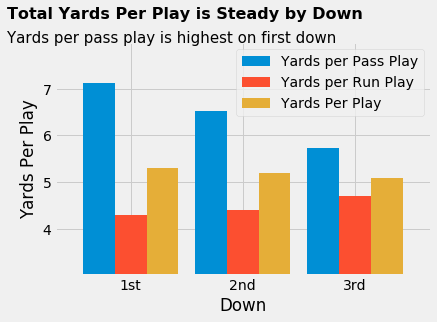

In [10]:
ax = table.plot.bar(width=0.85)

ax.tick_params(labelrotation=0)

ax.text(x=-1.1, y=8.5, s='Total Yards Per Play is Steady by Down', fontsize=16, fontweight='bold')
ax.text(x=-1.1, y=8, s='Yards per pass play is highest on first down', fontsize=15)
ax.set(
    xlabel='Down',
    ylabel='Yards Per Play',
    ylim=(3,8),
    yticks=range(4,8,1)
);

In [11]:
run_plays = run_plays[run_plays.down != 3]
pass_plays = pass_plays[pass_plays.down != 3]
cols = ['game_id','game_year', 'posteam']

run_plays_final = pd.merge(run_plays[cols], game_log_scores, on='game_id').dropna(subset=['home_score', 'away_score'])
pass_plays_final = pd.merge(pass_plays[cols], game_log_scores, on='game_id').dropna(subset=['home_score', 'away_score'])

run_plays_final['postwin'] = run_plays_final[run_plays_final.posteam == run_plays_final.home_team].home_win
run_plays_final['postwin'] = run_plays_final.postwin.fillna(~run_plays_final.home_win)
pass_plays_final['postwin'] = pass_plays_final[pass_plays_final.posteam == pass_plays_final.home_team].home_win
pass_plays_final['postwin'] = pass_plays_final.postwin.fillna(~pass_plays_final.home_win)

run_plays_final['get_home_total'] = (run_plays_final.posteam == run_plays_final.home_team)
run_plays_final['score_of_posteam'] = run_plays_final[run_plays_final.get_home_total == True].home_score
run_plays_final['score_of_posteam'] = run_plays_final.score_of_posteam.fillna(run_plays_final.away_score)

pass_plays_final['get_home_total'] = (pass_plays_final.posteam == pass_plays_final.home_team)
pass_plays_final['score_of_posteam'] = pass_plays_final[pass_plays_final.get_home_total == True].home_score
pass_plays_final['score_of_posteam'] = pass_plays_final.score_of_posteam.fillna(pass_plays_final.away_score)

In [12]:
import scipy.stats

print('The average final points for teams who ran on these early downs was: {}'.format(round(run_plays_final.score_of_posteam.mean(),2)))
print('The average final points for teams who passed on these early downs was: {}'.format(round(pass_plays_final.score_of_posteam.mean(),2)))
print('')
print('The t-stat for the null hypothesis is {}'.format(round(scipy.stats.ttest_ind(run_plays_final.score_of_posteam, pass_plays_final.score_of_posteam)[0],2)))
print('The p-value for the null hypothesis is {}%'.format(round(scipy.stats.ttest_ind(run_plays_final.score_of_posteam, pass_plays_final.score_of_posteam)[1] *100 ,3)))



The average final points for teams who ran on these early downs was: 22.62
The average final points for teams who passed on these early downs was: 23.38

The t-stat for the null hypothesis is -3.71
The p-value for the null hypothesis is 0.021%


In [13]:
print('The average win percentage for teams who ran on these early downs was: {}%'.format(round(run_plays_final.postwin.mean() * 100,2)))
print('The average win percentage for teams who passed on these early downs was: {}%'.format(round(pass_plays_final.postwin.mean() * 100,2)))
print('')
print('The t-stat for the null hypothesis is {}'.format(round(scipy.stats.ttest_ind(run_plays_final.postwin, pass_plays_final.postwin)[0],2)))
print('The p-value for the null hypothesis is {}%'.format(round(scipy.stats.ttest_ind(run_plays_final.postwin, pass_plays_final.postwin)[1] *100 ,3)))

The average win percentage for teams who ran on these early downs was: 52.17%
The average win percentage for teams who passed on these early downs was: 55.21%

The t-stat for the null hypothesis is -3.09
The p-value for the null hypothesis is 0.203%


In [14]:
postwin_over_time = final_pivot = pd.DataFrame({
    'Pass Early Win %': round(pass_plays_final.pivot_table(index='game_year', values='postwin').postwin * 100, 2),
    'Run Early Win %': round(run_plays_final.pivot_table(index='game_year', values='postwin').postwin * 100, 2),
    'Pass Early Final Points': round(pass_plays_final.pivot_table(index='game_year', values='score_of_posteam').score_of_posteam,1),
    'Run Early Final Points': round(run_plays_final.pivot_table(index='game_year', values='score_of_posteam').score_of_posteam,1)})

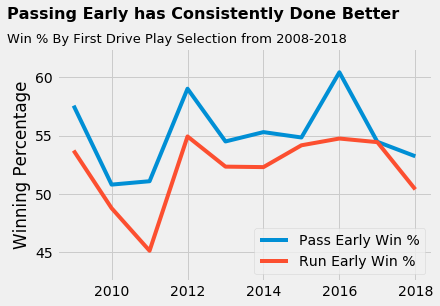

In [15]:
ax = postwin_over_time[['Pass Early Win %', 'Run Early Win %']].plot.line()

ax.text(x=2007.25, y=65, s='Passing Early has Consistently Done Better', fontsize=16, fontweight='bold')
ax.text(x=2007.25, y=63, s='Win % By First Drive Play Selection from 2008-2018', fontsize=13)
ax.legend(loc=4)
ax.set(ylim=(42.5,62.5),
       yticks=(range(45,65,5)),
       ylabel='Winning Percentage',
       xlabel='');

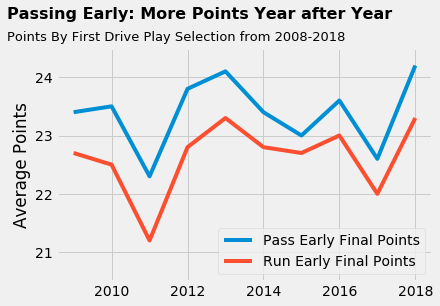

In [16]:
ax= postwin_over_time[['Pass Early Final Points', 'Run Early Final Points']].plot.line()

ax.text(x=2007.25, y=25, s='Passing Early: More Points Year after Year', fontsize=16, fontweight='bold')
ax.text(x=2007.25, y=24.62, s='Points By First Drive Play Selection from 2008-2018', fontsize=13);

ax.set(ylim=(20.5,24.5),
       yticks=(range(21,25,1)),
       xlabel='',
       ylabel='Average Points')
ax.legend(loc=4);

In [17]:
print('First down pass plays average {} yards per play.'.format(round(pass_plays[pass_plays.down == 1].yards_gained.mean(),1)))
print('First down run plays average {} yards per play.'.format(round(run_plays[run_plays.down == 1].yards_gained.mean(),2)))

First down pass plays average 7.1 yards per play.
First down run plays average 4.3 yards per play.


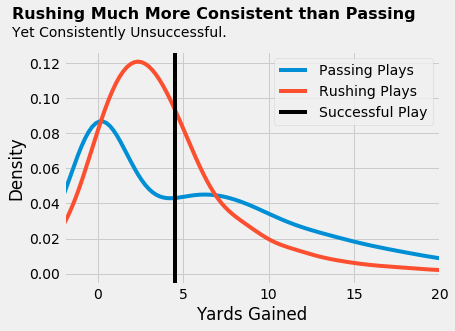

In [18]:
fig, ax = plt.subplots()

ax = pass_plays.yards_gained.plot.density(xlim=(-2,20), label='Passing Plays')
ax = run_plays.yards_gained.plot.density(xlim=(-2,20), label='Rushing Plays')
ax.set(xlabel='Yards Gained')

ax.text(x=-5, y= .145, s='Rushing Much More Consistent than Passing', fontsize=16,fontweight='bold')
ax.text(x=-5, y= .135, s='Yet Consistently Unsuccessful. ', fontsize=14)
plt.axvline(4.5, color='black', label='Successful Play')

plt.legend(loc='upper right');

In [19]:
suc_run = len(run_plays[((run_plays.yards_gained >= 5) & (run_plays.down == 1))].yards_gained) / len(run_plays[run_plays.down == 1].yards_gained)
suc_pass = len(pass_plays[((pass_plays.yards_gained >= 5) & (pass_plays.down == 1))].yards_gained) / len(pass_plays[pass_plays.down == 1].yards_gained)

print('A successful run occured on 1st & 10 about {}% of the time.'.format(round(suc_run * 100, 1)))
print('A successful pass occured on 1st & 10 about {}% of the time.'.format(round(suc_pass * 100, 1)))

A successful run occured on 1st & 10 about 33.9% of the time.
A successful pass occured on 1st & 10 about 51.5% of the time.
